In [69]:
import numpy as np
import cv2
import pywt
import matplotlib.pyplot as plt
from skimage import data
from skimage import color
from skimage import img_as_float
from skimage.io import imsave, imread
from skimage.measure import compare_ssim
from IPython.display import Image, display


In [70]:
def register_images(img_ref, img):
    orb = cv2.ORB_create(5000)

    kp_ref, desc_ref = orb.detectAndCompute(img_ref,None)

    #img = cv2.resize(img,img_ref.shape)
    kp, desc = orb.detectAndCompute(img, None)
    
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    # Match descriptors.
    matches = bf.match(desc, desc_ref)

    matches = sorted(matches, key = lambda x:x.distance)
    
    matches = matches[:int(len(matches)*0.7)] 
    no_of_matches = len(matches)
    
    matches_img = cv2.drawMatches(img,kp,img_ref,kp_ref,matches,None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.imshow(matches_img, cmap='gray')
    plt.title('Images Matches')
    plt.show()
    
    points_ref = np.zeros((no_of_matches, 2), dtype=np.float32)
    points = np.zeros((no_of_matches, 2), dtype=np.float32)
    
    for i, match in enumerate(matches):
        points_ref[i, :] = kp_ref[match.trainIdx].pt
        points[i, :] = kp[match.queryIdx].pt

    h, mask = cv2.findHomography(points, points_ref, cv2.RANSAC)
    
    height, width = img_ref.shape
    output = cv2.warpPerspective(img, h, (width, height))
    
    return output
    

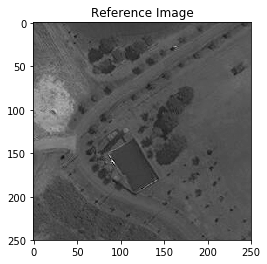

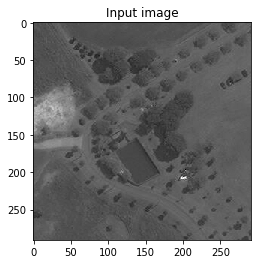

In [71]:
# Read images
img_ref = cv2.imread("referencia - Copia2.jpg",cv2.IMREAD_GRAYSCALE)
img = cv2.imread("GE01_2017_JPEG_R1C1 (3).jpg",cv2.IMREAD_GRAYSCALE)

plt.imshow(img_ref, cmap='gray')
plt.title('Reference Image')
plt.show()

plt.imshow(img, cmap='gray')
plt.title('Input image')
plt.show()

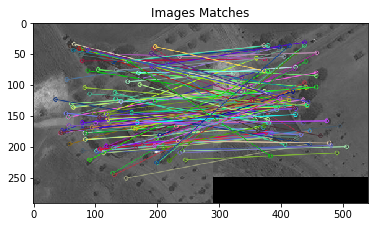

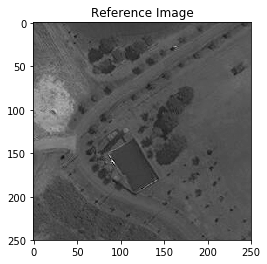

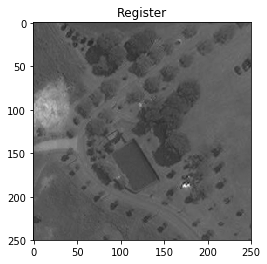

In [72]:
# Register input image

img_register = register_images(img_ref, img)

plt.imshow(img_ref, cmap='gray')
plt.title('Reference Image')
plt.show()

plt.imshow(img_register, cmap='gray')
plt.title('Register')
plt.show()

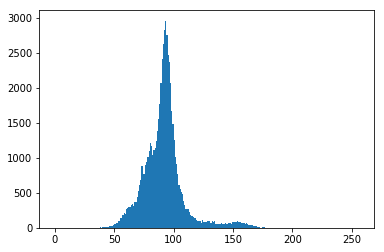

In [73]:
# Before normalize verify what are the most commom classes
plt.hist(img_ref.ravel(),256,[0,256]); 
plt.show()

In [74]:
# Grouping the pixels in 3 classes. 
def normalize_image(img):
    for x in range(len(img)-1):
        for y in range(len(img[x])-1):
            if img[x][y] < 90:
                img[x][y] = 50
            elif img[x][y] < 110:
                img[x][y] = 130
            else:
                img[x][y] = 255

    return img

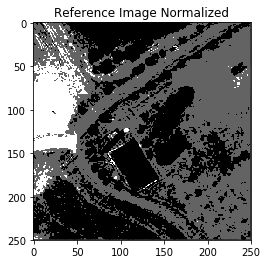

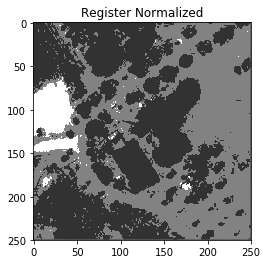

In [75]:
# Normalize both images
img_ref_normalized = normalize_image(img_ref)
img_register_normalized = normalize_image(img_register)

plt.imshow(img_ref_normalized, cmap='gray')
plt.title('Reference Image Normalized')
plt.show()

plt.imshow(img_register_normalized, cmap='gray')
plt.title('Register Normalized')
plt.show()

In [76]:
#Subtract one image from another
def sub_images(ref, img):
    fusedImage = cv2.subtract(ref, img)
    
    return fusedImage

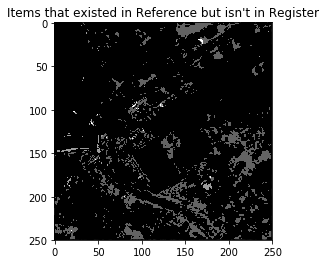

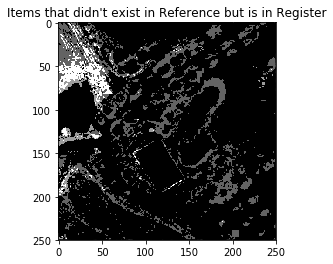

In [77]:
# Subtract one image from another and get the differences
things_disappeared = sub_images(img_register_normalized, img_ref_normalized)
things_appeared = sub_images(img_ref_normalized, img_register_normalized)
    
plt.imshow(things_disappeared, cmap="gray")
plt.title("Items that existed in Reference but isn't in Register")
plt.show()

plt.imshow(things_appeared, cmap="gray")
plt.title("Items that didn't exist in Reference but is in Register")
plt.show()

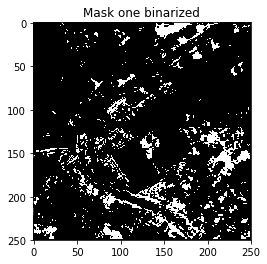

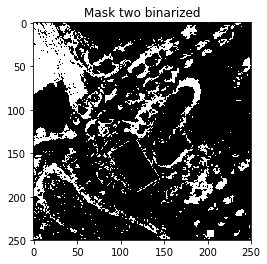

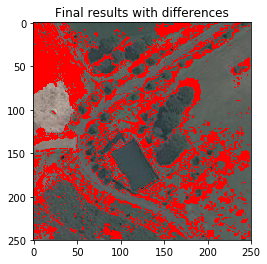

In [83]:
# Binarize masks of diferences' images
img_ref_color = cv2.imread("referencia - Copia2.jpg")

ret, mask = cv2.threshold(things_disappeared, 50, 255,cv2.THRESH_BINARY )

plt.imshow(mask, cmap="gray")
plt.title("Mask one binarized")
plt.show()

img_ref_color[mask != 0] = [0, 0, 255]

ret, mask = cv2.threshold(things_appeared, 50, 255,cv2.THRESH_BINARY )

plt.imshow(mask, cmap="gray")
plt.title("Mask two binarized")
plt.show()

img_ref_color[mask != 0] = [0, 0, 255]


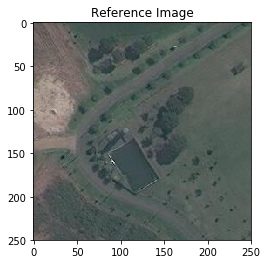

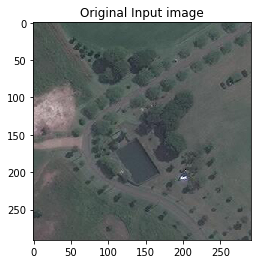

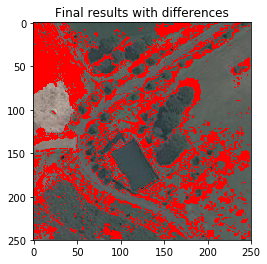

In [84]:
img_ref = cv2.imread("referencia - Copia2.jpg")
img = cv2.imread("GE01_2017_JPEG_R1C1 (3).jpg")

plt.imshow(cv2.cvtColor(img_ref, cv2.COLOR_BGR2RGB))
plt.title("Reference Image")
plt.show()

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Input image")
plt.show()

plt.imshow(cv2.cvtColor(img_ref_color, cv2.COLOR_BGR2RGB))
plt.title("Final results with differences")
plt.show()